# Importing the necessary modules

In [ ]:
import os
from pathlib import Path

import tensorflow as tf
import numpy as np

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import shutil
import random
import zipfile

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix



# Downloading and Organizing the Data

In [ ]:
dataset_url = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"

data_zipfile = tf.keras.utils.get_file(origin = dataset_url, fname = '/tmp/kvasir.zip', extract = False)

2489319424/2489312085 [==============================] - 658s 0us/step


In [ ]:
zip_ref = zipfile.ZipFile('/tmp/kvasir.zip','r')
zip_ref.extractall('/tmp')
zip_ref.close()

#split the extracted stuff into training and validation directories.

#make the directories
os.mkdir('/tmp/kvasir')
os.mkdir('/tmp/kvasir/train')
os.mkdir('/tmp/kvasir/test')

#find label names
labels = os.listdir('/tmp/kvasir-dataset-v2')
print(labels)

train_dir = '/tmp/kvasir/train'
test_dir = '/tmp/kvasir/test'

for i in labels:
  os.mkdir(train_dir+"/"+i)
  os.mkdir(test_dir+"/"+i)

['normal-cecum', 'normal-z-line', 'esophagitis', 'polyps', 'ulcerative-colitis', 'dyed-lifted-polyps', 'dyed-resection-margins', 'normal-pylorus']


In [ ]:
def split_data(source,train,test,split):

  data = os.listdir(source)
  len_data = len(data)
  data = random.sample(data,len_data)

  for i in range(len_data):

    file = source + "/" + data[i]   #filename and path

    if not os.path.getsize(file)>0:
      print(data[i] + " is zero length, ignoring it.")

    elif (i<split*len_data):
      shutil.copyfile(file,train+"/"+data[i])

    else:
      shutil.copyfile(file,test+"/"+data[i])


split_size = 0.8

for i in labels:
  split_data("/tmp/kvasir-dataset-v2/"+i, train_dir+"/"+i, test_dir+"/"+i,split_size)


In [ ]:
#finally everything is split nicely, now we can point image data generator at this directory structure

print(len(os.listdir('/tmp/kvasir/test/ulcerative-colitis'))) #just a test

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory(
    train_dir,
    batch_size=80,
    class_mode='sparse',
    target_size=(288,360)
)

test_ds = test_generator.flow_from_directory(
    test_dir,
    batch_size=80,
    shuffle=False,
    class_mode='sparse',
    target_size=(288,360)
)



200
Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


#Testing VGG-16

In [ ]:
train_ds_new = train_generator.flow_from_directory(
    train_dir,
    batch_size=80,
    class_mode='sparse',
    target_size=(224,224)
)

test_ds_new = test_generator.flow_from_directory(
    test_dir,
    batch_size=80,
    shuffle=False,
    class_mode='sparse',
    target_size=(224,224)
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

#Since we don’t have to train all the layers, we make them non_trainable:
for layer in base_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (8,activation='softmax')(x)           


new_vgg_model = tf.keras.models.Model(base_model.input, x)

new_vgg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = new_vgg_model.fit(
    train_ds_new,
    epochs=10,
    #batch_size=20,
    #verbose=1,
    validation_data=test_ds_new
)


Epoch 1/10
80/80 [==============================] - 183s 2s/step - loss: 3.8851 - accuracy: 0.2707 - val_loss: 1.0205 - val_accuracy: 0.6256
Epoch 2/10
80/80 [==============================] - 178s 2s/step - loss: 1.2219 - accuracy: 0.4989 - val_loss: 0.8642 - val_accuracy: 0.6712
Epoch 3/10
80/80 [==============================] - 179s 2s/step - loss: 1.0755 - accuracy: 0.5442 - val_loss: 0.7527 - val_accuracy: 0.7050
Epoch 4/10
80/80 [==============================] - 174s 2s/step - loss: 0.9623 - accuracy: 0.5889 - val_loss: 0.6956 - val_accuracy: 0.7194
Epoch 5/10
80/80 [==============================] - 175s 2s/step - loss: 0.9417 - accuracy: 0.6046 - val_loss: 0.6749 - val_accuracy: 0.7219
Epoch 6/10
80/80 [==============================] - 174s 2s/step - loss: 0.9294 - accuracy: 0.6060 - val_loss: 0.6388 - val_accuracy: 0.7325
Epoch 7/10
80/80 [==============================] - 174s 2s/step - loss: 0.9040 - accuracy: 0.6190 - val_loss: 0.6459 - val_accuracy: 0.7469
Epoch 8/10
80

In [ ]:
new_vgg_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history2 = new_vgg_model.fit(
    train_ds_new,
    epochs=10,
    #batch_size=20,
    #verbose=1,
    validation_data=test_ds_new
)

Epoch 1/10
80/80 [==============================] - 176s 2s/step - loss: 0.7517 - accuracy: 0.6861 - val_loss: 0.5318 - val_accuracy: 0.7837
Epoch 2/10
80/80 [==============================] - 173s 2s/step - loss: 0.7316 - accuracy: 0.6907 - val_loss: 0.5436 - val_accuracy: 0.7706
Epoch 3/10
80/80 [==============================] - 172s 2s/step - loss: 0.7243 - accuracy: 0.7019 - val_loss: 0.5326 - val_accuracy: 0.7750
Epoch 4/10
80/80 [==============================] - 172s 2s/step - loss: 0.7481 - accuracy: 0.6910 - val_loss: 0.5274 - val_accuracy: 0.7800
Epoch 5/10
80/80 [==============================] - 173s 2s/step - loss: 0.7321 - accuracy: 0.6980 - val_loss: 0.5250 - val_accuracy: 0.7825
Epoch 6/10
80/80 [==============================] - 174s 2s/step - loss: 0.7108 - accuracy: 0.7099 - val_loss: 0.5219 - val_accuracy: 0.7862
Epoch 7/10
80/80 [==============================] - 175s 2s/step - loss: 0.7154 - accuracy: 0.7094 - val_loss: 0.5176 - val_accuracy: 0.7806
Epoch 8/10
80

In [ ]:
print(new_vgg_model.evaluate(test_ds))

NameError: ignored

#Testing Inception v3

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (288, 360, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
#pre_trained_model.summary()

--2021-03-09 04:58:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  39.7MB/s    in 2.1s    

2021-03-09 04:59:00 (39.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128,activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8,activation='softmax')(x)           

transfer_model = Model(pre_trained_model.input, x) 
#transfer_model.summary()

last layer output shape:  (None, 16, 20, 768)


In [ ]:

transfer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = transfer_model.fit(
    train_ds,
    epochs=10,
    #batch_size=20,
    #verbose=1,
    validation_data=test_ds
)

Epoch 1/10
80/80 [==============================] - 269s 3s/step - loss: 2.9744 - accuracy: 0.3649 - val_loss: 0.6009 - val_accuracy: 0.7919
Epoch 2/10
80/80 [==============================] - 241s 3s/step - loss: 0.7935 - accuracy: 0.6650 - val_loss: 0.4425 - val_accuracy: 0.8344
Epoch 3/10
80/80 [==============================] - 242s 3s/step - loss: 0.7287 - accuracy: 0.6972 - val_loss: 0.4151 - val_accuracy: 0.8456
Epoch 4/10
80/80 [==============================] - 241s 3s/step - loss: 0.6509 - accuracy: 0.7262 - val_loss: 0.3796 - val_accuracy: 0.8594
Epoch 5/10
80/80 [==============================] - 241s 3s/step - loss: 0.6384 - accuracy: 0.7198 - val_loss: 0.3535 - val_accuracy: 0.8712
Epoch 6/10
80/80 [==============================] - 241s 3s/step - loss: 0.6282 - accuracy: 0.7381 - val_loss: 0.3459 - val_accuracy: 0.8606
Epoch 7/10
80/80 [==============================] - 241s 3s/step - loss: 0.6200 - accuracy: 0.7398 - val_loss: 0.3491 - val_accuracy: 0.8706
Epoch 8/10
80

Text(0.5, 1.0, 'Training and validation loss')

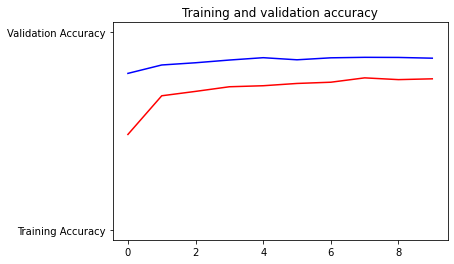

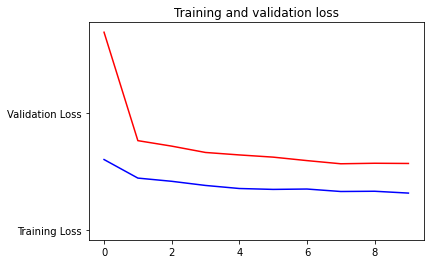

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
print(transfer_model.evaluate(test_ds))

20/20 [==============================] - 25s 1s/step - loss: 0.3144 - accuracy: 0.8687
[0.31443217396736145, 0.8687499761581421]


In [ ]:
labels_dict = test_ds.class_indices
print(labels_dict)

{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}


# Detailed Evaluation of Inception v3 model

In [ ]:
#Evaluating a single image! 

#Replace this path with the path to any image u wish. 

img = image.load_img(Path('/tmp/kvasir-dataset-v2/polyps/006338df-e61e-4725-bb6c-dd0620f11cdc.jpg'), target_size=(288, 360))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
#classes = transfer_model.predict(images)
#np.argmax(classes,axis=1)

tryy = test_generator.flow(images)
predicted = transfer_model.predict(tryy)
index = np.argmax(predicted,axis=1)[0]

for key,item in labels_dict.items():
  if item==index:
    print("Image belongs to the class: " + key)


Image belongs to the class: polyps


In [ ]:
#Manually written code to understand how the model uses the Generator to make predictions
#Will take the predictions and actual classes from here to manually calculate confusion matrix

#there are 1600 images in test_ds, batch size is 80. Will use 20 batches

pred_classes = []
actual_classes = []

batch = 0 

for i,t in test_ds:
    
    if batch >=20: break
    
    batch+=1
    
    print("Batch " + str(batch))
    
    preds = transfer_model.predict(i)
    preds = np.argmax(preds,axis=1)
    actual = t
    
    len_preds = len(preds)
    
    correct = 0
    
    for k in range(len_preds):
        
        pred_classes.append(preds[k])
        actual_classes.append(actual[k])
        
        if preds[k]==actual[k]:
            correct+=1
            
    print("No. correct " + str(correct) + " out of " + str(len_preds))
    
    
#print(pred_classes)
#print(actual_classes)

#print(len(pred_classes))
#print(len(actual_classes))

a=0

for k in range(1600):
    if pred_classes[k]==actual_classes[k]:
        a+=1
        
print(str(a) + " out of " + str(len(pred_classes)))
    

Batch 1
No. correct 65 out of 80
Batch 2
No. correct 53 out of 80
Batch 3
No. correct 65 out of 80
Batch 4
No. correct 74 out of 80
Batch 5
No. correct 73 out of 80
Batch 6
No. correct 54 out of 80
Batch 7
No. correct 60 out of 80
Batch 8
No. correct 61 out of 80
Batch 9
No. correct 76 out of 80
Batch 10
No. correct 78 out of 80
Batch 11
No. correct 79 out of 80
Batch 12
No. correct 78 out of 80
Batch 13
No. correct 75 out of 80
Batch 14
No. correct 71 out of 80
Batch 15
No. correct 70 out of 80
Batch 16
No. correct 70 out of 80
Batch 17
No. correct 69 out of 80
Batch 18
No. correct 68 out of 80
Batch 19
No. correct 76 out of 80
Batch 20
No. correct 75 out of 80
1390 out of 1600


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(actual_classes, pred_classes))

Confusion Matrix
[[145  52   0   0   0   0   3   0]
 [ 15 185   0   0   0   0   0   0]
 [  0   0 137   0   4  59   0   0]
 [  1   1   0 192   0   0   2   4]
 [  0   0   2   0 195   2   0   1]
 [  0   0  19   0   3 178   0   0]
 [  1   1   0  17   0   0 169  12]
 [  1   1   2   7   0   0   0 189]]


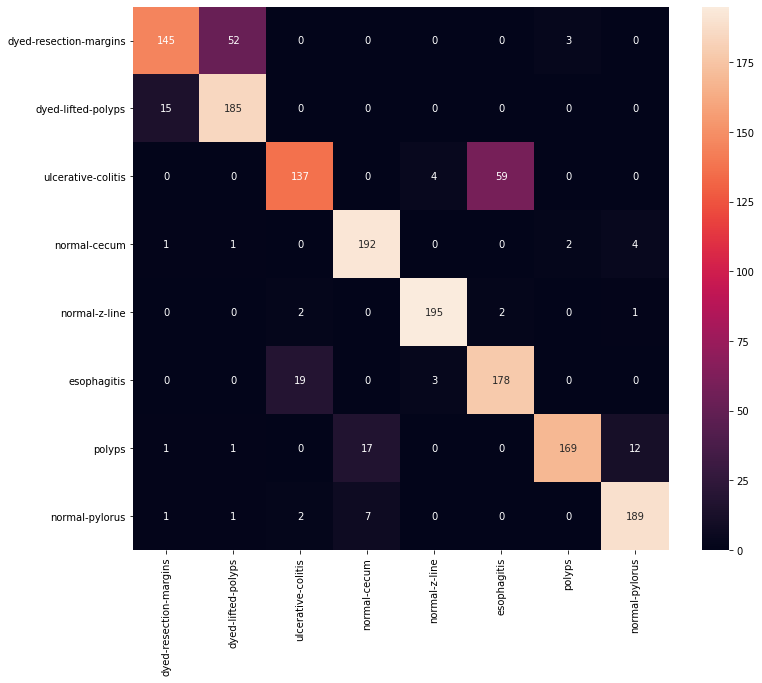

In [ ]:
import pandas as pd
import seaborn as sn
target_names =['dyed-resection-margins', 'dyed-lifted-polyps', 'ulcerative-colitis', 'normal-cecum', 'normal-z-line', 'esophagitis', 'polyps', 'normal-pylorus']
array=confusion_matrix(actual_classes, pred_classes)
df_cm = pd.DataFrame(array, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True,fmt="d")

In [ ]:
print('Classification Report')
target_names =['dyed-resection-margins', 'dyed-lifted-polyps', 'ulcerative-colitis', 'normal-cecum', 'normal-z-line', 'esophagitis', 'polyps', 'normal-pylorus']
print(classification_report(actual_classes, pred_classes, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

dyed-resection-margins       0.89      0.72      0.80       200
    dyed-lifted-polyps       0.77      0.93      0.84       200
    ulcerative-colitis       0.86      0.69      0.76       200
          normal-cecum       0.89      0.96      0.92       200
         normal-z-line       0.97      0.97      0.97       200
           esophagitis       0.74      0.89      0.81       200
                polyps       0.97      0.84      0.90       200
        normal-pylorus       0.92      0.94      0.93       200

              accuracy                           0.87      1600
             macro avg       0.88      0.87      0.87      1600
          weighted avg       0.88      0.87      0.87      1600



#Testing a basic model without transfer learning


In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32,(10,10),activation='relu',input_shape=(288,360,3)),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Conv2D(32,(10,10),activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 279, 351, 32)      9632      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 93, 117, 32)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 84, 108, 32)       102432    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32256)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(
    train_ds,
    epochs=10,
    #batch_size=20,
    #verbose=1,
    validation_data=test_ds
)

Epoch 1/10
80/80 [==============================] - 239s 3s/step - loss: 1.9326 - accuracy: 0.2292 - val_loss: 1.0825 - val_accuracy: 0.5175
Epoch 2/10
80/80 [==============================] - 240s 3s/step - loss: 1.1394 - accuracy: 0.4871 - val_loss: 0.8956 - val_accuracy: 0.5831
Epoch 3/10
80/80 [==============================] - 236s 3s/step - loss: 1.0087 - accuracy: 0.5435 - val_loss: 1.0485 - val_accuracy: 0.5125
Epoch 4/10
80/80 [==============================] - 238s 3s/step - loss: 1.0424 - accuracy: 0.5248 - val_loss: 0.8486 - val_accuracy: 0.6300
Epoch 5/10
80/80 [==============================] - 240s 3s/step - loss: 0.8873 - accuracy: 0.5901 - val_loss: 0.8120 - val_accuracy: 0.6094
Epoch 6/10
80/80 [==============================] - 237s 3s/step - loss: 0.8689 - accuracy: 0.6030 - val_loss: 0.7270 - val_accuracy: 0.6481
Epoch 7/10
80/80 [==============================] - 235s 3s/step - loss: 0.9177 - accuracy: 0.5752 - val_loss: 0.7903 - val_accuracy: 0.6388
Epoch 8/10
80

Text(0.5, 1.0, 'Training and validation loss')

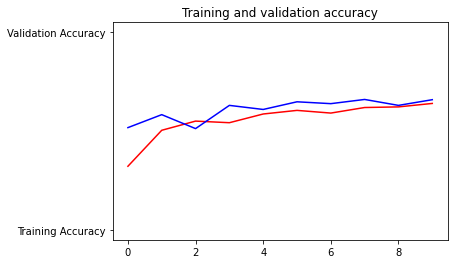

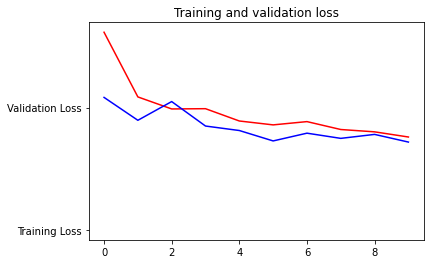

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
print(model.evaluate(test_ds))

20/20 [==============================] - 24s 1s/step - loss: 0.7177 - accuracy: 0.6587
[0.7176518440246582, 0.6587499976158142]


In [ ]:

  #Manually written code to understand how the model uses the Generator to make predictions
#Will take the predictions and actual classes from here to manually calculate confusion matrix

#there are 1600 images in test_ds, batch size is 80. Will use 20 batches

pred_classes = []
actual_classes = []

batch = 0 

for i,t in test_ds:
    
    if batch >=20: break
    
    batch+=1
    
    print("Batch " + str(batch))
    
    preds = model.predict(i)
    preds = np.argmax(preds,axis=1)
    actual = t
    
    len_preds = len(preds)
    
    correct = 0
    
    for k in range(len_preds):
        
        pred_classes.append(preds[k])
        actual_classes.append(actual[k])
        
        if preds[k]==actual[k]:
            correct+=1
            
    print("No. correct " + str(correct) + " out of " + str(len_preds))
    
    
#print(pred_classes)
#print(actual_classes)

#print(len(pred_classes))
#print(len(actual_classes))

a=0

for k in range(1600):
    if pred_classes[k]==actual_classes[k]:
        a+=1
        
print(str(a) + " out of " + str(len(pred_classes)))

Batch 1
No. correct 57 out of 80
Batch 2
No. correct 51 out of 80
Batch 3
No. correct 43 out of 80
Batch 4
No. correct 37 out of 80
Batch 5
No. correct 71 out of 80
Batch 6
No. correct 70 out of 80
Batch 7
No. correct 73 out of 80
Batch 8
No. correct 70 out of 80
Batch 9
No. correct 75 out of 80
Batch 10
No. correct 73 out of 80
Batch 11
No. correct 78 out of 80
Batch 12
No. correct 49 out of 80
Batch 13
No. correct 21 out of 80
Batch 14
No. correct 17 out of 80
Batch 15
No. correct 39 out of 80
Batch 16
No. correct 38 out of 80
Batch 17
No. correct 46 out of 80
Batch 18
No. correct 44 out of 80
Batch 19
No. correct 47 out of 80
Batch 20
No. correct 55 out of 80
1054 out of 1600


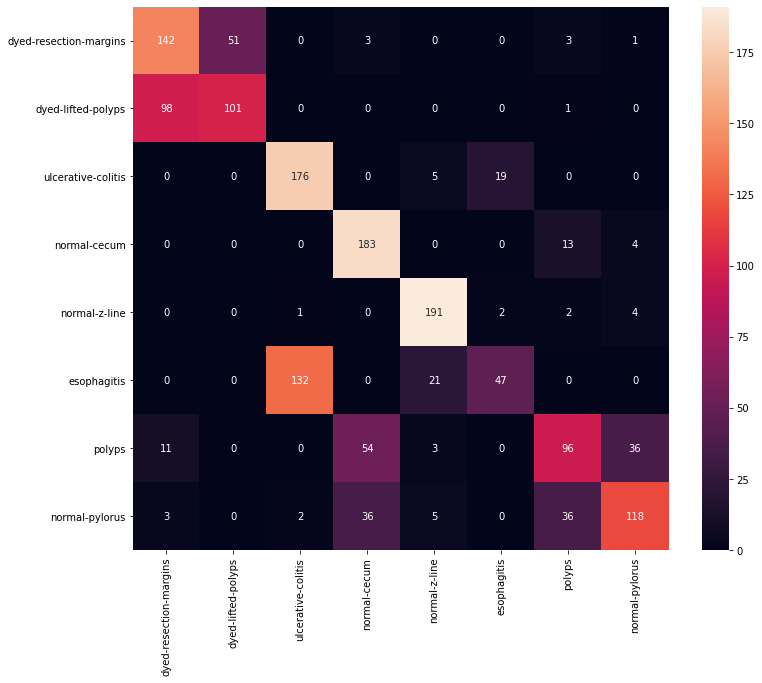

In [ ]:
import pandas as pd
import seaborn as sn
target_names =['dyed-resection-margins', 'dyed-lifted-polyps', 'ulcerative-colitis', 'normal-cecum', 'normal-z-line', 'esophagitis', 'polyps', 'normal-pylorus']
array=confusion_matrix(actual_classes, pred_classes)
df_cm = pd.DataFrame(array, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True,fmt="d")

In [ ]:
print('Classification Report')
target_names =['dyed-resection-margins', 'dyed-lifted-polyps', 'ulcerative-colitis', 'normal-cecum', 'normal-z-line', 'esophagitis', 'polyps', 'normal-pylorus']
print(classification_report(actual_classes, pred_classes, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

dyed-resection-margins       0.56      0.71      0.63       200
    dyed-lifted-polyps       0.66      0.51      0.57       200
    ulcerative-colitis       0.57      0.88      0.69       200
          normal-cecum       0.66      0.92      0.77       200
         normal-z-line       0.85      0.95      0.90       200
           esophagitis       0.69      0.23      0.35       200
                polyps       0.64      0.48      0.55       200
        normal-pylorus       0.72      0.59      0.65       200

              accuracy                           0.66      1600
             macro avg       0.67      0.66      0.64      1600
          weighted avg       0.67      0.66      0.64      1600



#Testing resnet50
 

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(input_shape=(288,360,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model_resnet.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model_resnet = Sequential()
base_model_resnet.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
# Add a final sigmoid layer for classification
base_model_resnet.add(Dense  (8,activation='softmax'))  
base_model_resnet.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])


In [ ]:
resnet_history = base_model_resnet.fit(train_ds, validation_data = test_ds, epochs = 10)


Epoch 1/10
80/80 [==============================] - 294s 3s/step - loss: 8.9121 - acc: 0.2025 - val_loss: 6.2355 - val_acc: 0.1425
Epoch 2/10
80/80 [==============================] - 261s 3s/step - loss: 3.0819 - acc: 0.4795 - val_loss: 7.7278 - val_acc: 0.1506
Epoch 3/10
80/80 [==============================] - 261s 3s/step - loss: 2.3455 - acc: 0.5829 - val_loss: 7.6607 - val_acc: 0.1294
Epoch 4/10
80/80 [==============================] - 261s 3s/step - loss: 1.9278 - acc: 0.6482 - val_loss: 7.2029 - val_acc: 0.1213
Epoch 5/10
80/80 [==============================] - 260s 3s/step - loss: 1.7026 - acc: 0.6809 - val_loss: 7.4011 - val_acc: 0.1306
Epoch 6/10
80/80 [==============================] - 260s 3s/step - loss: 1.4456 - acc: 0.7129 - val_loss: 6.5253 - val_acc: 0.1681
Epoch 7/10
80/80 [==============================] - 260s 3s/step - loss: 1.3082 - acc: 0.7406 - val_loss: 6.7086 - val_acc: 0.1937
Epoch 8/10
80/80 [==============================] - 260s 3s/step - loss: 1.1786 - a